<a href="https://colab.research.google.com/github/raheelam98/LangGraph/blob/main/langchain_ecosystem/langgraph/course-notebooks/module-1/5_agent_memory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**rm note**

state:- structure of work flow

memory :- presisten memory (store things)

API :- talk one meachine to another meachine


**Module 1 :**  3_router.ipynb(Revision), 4_agent.ipynb(Revision),5_agent_memory.ipynb

**advanced_features :** rag, fine tunning, function calling

**Github**

[learn-agentic-ai - 10_advanced_features - Github](https://github.com/panaversity/learn-agentic-ai/tree/main/10_advanced_features)

**Video**

[Class-04: Mastering LangGraph In a New Way: Memory, RAG, Fine Tuning, GraphRAG, AI Agents - Nov 15, 2024](https://www.youtube.com/watch?v=Zf2C8A6RmJE&t=8143s)

# Agent memory

## Review

Previously, we built an agent that can:

* `act` - let the model call specific tools
* `observe` - pass the tool output back to the model
* `reason` - let the model reason about the tool output to decide what to do next (e.g., call another tool or just respond directly)

![Screenshot 2024-08-21 at 12.45.32 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbab7453080e6802cd1703_agent-memory1.png)

## Goals

Now, we're going extend our agent by introducing memory.

In [ ]:
%%capture --no-stderr
%pip install --quiet -U langchain_google_genai langchain_core langgraph

In [ ]:

import os

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "angchain-academy"

In [ ]:
from google.colab import userdata
gemini_api_key = userdata.get('GEMINI_API_KEY')

We'll use [LangSmith](https://docs.smith.langchain.com/) for [tracing](https://docs.smith.langchain.com/concepts/tracing).

In [ ]:
from google.colab import userdata
LANGCHAIN_API_KEY= userdata.get('LANGCHAIN_API_KEY')

In [ ]:
# ChatGoogleGenerativeAI
from langchain_google_genai.chat_models import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash", api_key = gemini_api_key)

In [ ]:
# check llm is working
result = llm.invoke("hi")
result

/usr/local/lib/python3.10/dist-packages/langsmith/client.py:241: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


AIMessage(content='Hi there! How can I help you today?\n', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-65cea185-ceee-4a6f-b7b5-7f485d726d6a-0', usage_metadata={'input_tokens': 2, 'output_tokens': 11, 'total_tokens': 13, 'input_token_details': {'cache_read': 0}})

This follows what we did previously.

**Note:** Obtain the necessary json key from the Google Cloud Console by following the instructions outlined in step 21_langchain_ecosystem/langchain/-01_gemini_standalone/Gemini_API_python.ipynb file. Once acquired, load the json key in Google Colab to proceed with the project.

In [ ]:
# import os
# os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/content/<your-json-key-here>"

In [ ]:
# making criteria (point 1)

def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools = [add, multiply, divide]

# providing information to lainchain (point 2)

# Bind the tools to LLM
llm_with_tools = llm.bind_tools(tools)

In [ ]:
result = multiply(2,3)
print("Answer of mutiplication ",result)

result = add(2,3)
print("Answer of addition ",result)

result = divide(2,3)
print("Answer of division ",result)

Answer of mutiplication  6
Answer of addition  5
Answer of division  0.6666666666666666


**rm notes**

First imports necessary modules, sets a system message defining the assistant’s role, and defines a function to process messages and generate responses using a language model. This setup allows the assistant to handle arithmetic tasks based on user inputs and context.

In [ ]:
# Import necessary modules from langgraph and langchain_core
from langgraph.graph import MessagesState
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage, ToolMessage

# # System message (use to increase performance)
# Define a system message to establish the assistant's role
# This message sets the context for the assistant's behavior
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# # Node (create assistant node)
# Define a function named 'assistant' that takes a MessagesState as input
def assistant(state: MessagesState) -> MessagesState:
    # Invoke the LLM with tools using the system message and the current state of messages
    # The response is returned in a dictionary format, appended to the 'messages' key
    return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"]) ] }

    # Main :- llm_with_tools.invoke([sys_msg] + state["messages"])
    # ensures the assistant uses both the predefined context and the conversation history to respond appropriately

    # step 1 : System Message Inclusion: :- llm_with_tools.invoke([sys_msg]
    # calls the language model with just the system message, which establishes the context for the assistant.

    # step 2 : Combined Messages Processing :-  llm_with_tools.invoke(state["messages"])
    # processes the current conversation history (state messages)
    # by including them along with the system message to generate a coherent
    # response considering both the context and the history.



**rm notes**

```bash
from langgraph.graph import MessagesState
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

# # System message (create system message for better performance)
sys_msg = SystemMessage(content="You message.")
```

Node (create assistant node)

**Functionality :** Takes input, combines it with the system message, sends them to the LLM, and stores the LLM's response.

When the function gets the prompt, it sends it to the LLM along with both the system message and the prompt

```bash
def assistant(state: MessagesState) -> MessagesState:
    return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}
```

**Detail**

Define a function named 'assistant' that takes a MessagesState as input

**`def assistant(state: MessagesState) -> MessagesState:`**

This code calls the language model with both the system message and the current conversation history to generate a relevant response.

**`[llm_with_tools.invoke([sys_msg] + state["messages"]) ]`**


**Combined Messages Processing :**
**`[llm_with_tools.invoke([sys_msg] + state["messages"])]`**

This step makes sure the assistant takes into account both the initial instructions and the entire conversation so far to respond appropriately.

* **Including the System Message : `(sys_msg)`** Adding the initial instruction **`(sys_msg)`** to the list of messages. This sets the context for the assistant.

* **Processing Conversation History : `state["messages"]`** Combining the system message with the existing conversation history (all previous messages in **`state["messages"]`**). This ensures the assistant understands the context and history to generate a relevant and coherent response.

  

In [ ]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode
from IPython.display import Image, display
from langgraph.graph.state import CompiledStateGraph

# Graph
builder: StateGraph = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")
react_graph: CompiledStateGraph = builder.compile()



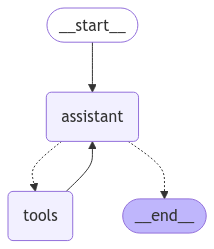

In [ ]:
# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

## Memory

Let's run our agent, as before.

In [ ]:
# Transient State: start a new chat session
messages = [HumanMessage(content="Add 2 and 4.")]
messages = react_graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 2 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (ed95b57d-8cd1-475a-9a3f-e64cd377d8b6)
 Call ID: ed95b57d-8cd1-475a-9a3f-e64cd377d8b6
  Args:
    a: 2.0
    b: 4.0
================================= Tool Message =================================
Name: add

6
================================== Ai Message ==================================

The sum of 2 and 4 is 6.


Now, let's multiply by 2!

In [ ]:
# Steady State : remember details from earlier conversations (not steady state)
messages = [HumanMessage(content="Multiply that by 3.")]
messages = react_graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiply that by 3.
================================== Ai Message ==================================

What would you like me to multiply by 3?  I need a number to perform this operation.



We don't retain memory of 7 from our initial chat!

This is because [state is transient](https://github.com/langchain-ai/langgraph/discussions/352#discussioncomment-9291220) to a single graph execution.

Of course, this limits our ability to have multi-turn conversations with interruptions.

We can use [persistence](https://langchain-ai.github.io/langgraph/how-tos/persistence/) to address this!

LangGraph can use a checkpointer to automatically save the graph state after each step.

This built-in persistence layer gives us memory, allowing LangGraph to pick up from the last state update.

One of the easiest checkpointers to use is the `MemorySaver`, an in-memory key-value store for Graph state.

All we need to do is simply compile the graph with a checkpointer, and our graph has memory!

**rm note**

**Don't retain memory from the initial chat!** because it don't has memory only has state

When the graph starts and runs, after finishing, the graph state is lost because it gets overwritten.

**Transient State :** Starts a new chat session.

**Steady State :** Remembers details from earlier conversations


# Transient State vs. Steady State

In computing and system behavior, we often encounter two states: transient and steady.

1. **Transient State**:
   - **Definition**: Transient state refers to the moments right after a change occurs. It's a temporary, dynamic condition.
   - **Example**: When you start a new chat session, your memory is transient—you're catching up, refreshing your context, and getting back into the conversation groove.

2. **Steady State**:
   - **Definition**: Steady state represents a stable, predictable condition. It's when a system settles into an equilibrium.
   - **Example**: As our chat progresses and we remember details from earlier conversations, we move toward a steady state.

Remember, in a single chat session (or graph execution), we experience both transient and steady states. Each interaction contributes to our overall understanding.



**rm notes**


To retain conversations, LangGraph uses **`persistent checkpointing`**.

```bash
react_graph_memory: CompiledStateGraph = builder.compile(checkpointer=memory)
```

LangGraph automatically saves the state after each step. When the graph is invoked again using the same **`thread_id`**, it loads its saved state, allowing the chatbot to continue from where it left off

**Note : Sequential tasks in LangGraph :**

**LangGraph only performs parallel tasks**. To make sequential tasks, we have to design the architecture to make it sequential

**State**

**Note : Checkpoints are Saved in a thread:**

Threads act as memory locations where the state is saved.

Through the **`thread_id`**, the state is saved into the memory location.

**Note : MemorySaver :**

MemorySaver retains the state while connected. Once disconnected, the data is lost

In [ ]:
from langgraph.checkpoint.memory import MemorySaver
memory: MemorySaver = MemorySaver()
react_graph_memory: CompiledStateGraph = builder.compile(checkpointer=memory)

When we use memory, we need to specify a `thread_id`.

This **`thread_id`** will store our memory location of graph states.

Here is a cartoon:

* The checkpointer write the state at every step of the graph
* These checkpoints are saved in a thread
* We can access that thread in the future using the `thread_id`

![state.jpg](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e0e9f526b41a4ed9e2d28b_agent-memory2.png)


In [ ]:
# Specify a thread
config = {"configurable": {"thread_id": "1"}}

In [ ]:
# Specify an input (sequentional )
# Create a list of messages with a HumanMessage containing the content "Add 3 and 4."
messages = [HumanMessage(content="Add 5 and 2.")]

# Run
# Invoke the graph with the specified messages and configuration
messages = react_graph_memory.invoke({"messages": messages}, config)

# Iterate through the resulting messages
for m in messages['messages']:
    # Print each message in a formatted ma
    m.pretty_print()


================================ Human Message =================================

Add 5 and 2.
================================== Ai Message ==================================
Tool Calls:
  add (0a134037-7d52-49bd-9f49-b6e6e10eca94)
 Call ID: 0a134037-7d52-49bd-9f49-b6e6e10eca94
  Args:
    a: 5.0
    b: 2.0
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

The sum of 5 and 2 is 7.


If we pass the same `thread_id`, then we can proceed from the previously logged state checkpoint!

In this case, the above conversation is captured in the thread.

The `HumanMessage` we pass (`"Multiply that by 3."`) is appended to the above conversation.

So, the model now know that `that` refers to the `The sum of 3 and 4 is 7.`.

In [ ]:
# Specify an input (sequentional )
# Create a list of messages with a HumanMessage containing the content "Add 3 and 4."
messages = [HumanMessage(content="Multiply that by 3.")]

# Run
# Invoke the graph with the specified messages and configuration
messages = react_graph_memory.invoke({"messages": messages}, config)

# Iterate through the resulting messages
for m in messages['messages']:
    # Print each message in a formatted ma
    m.pretty_print()

================================ Human Message =================================

Add 5 and 2.
================================== Ai Message ==================================
Tool Calls:
  add (0a134037-7d52-49bd-9f49-b6e6e10eca94)
 Call ID: 0a134037-7d52-49bd-9f49-b6e6e10eca94
  Args:
    a: 5.0
    b: 2.0
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

The sum of 5 and 2 is 7.
================================ Human Message =================================

Multiply that by 3.
================================== Ai Message ==================================
Tool Calls:
  multiply (02f6cef3-b387-40bf-a38a-0f53291a6567)
 Call ID: 02f6cef3-b387-40bf-a38a-0f53291a6567
  Args:
    a: 7.0
    b: 3.0
================================= Tool Message =================================
Name: multiply

21
================================== Ai Message =====================

In [ ]:
# Specify an input (parallel )
# Create a list of messages with a HumanMessage containing the content "Add 3 and 4."
messages = [HumanMessage(content="Add 3 to 2 and divide 4 by 2")]

# Run
# Invoke the graph with the specified messages and configuration
messages = react_graph_memory.invoke({"messages": messages}, config)

# Iterate through the resulting messages
for m in messages['messages']:
    # Print each message in a formatted ma
    m.pretty_print()

================================ Human Message =================================

Add 5 and 2.
================================== Ai Message ==================================
Tool Calls:
  add (0a134037-7d52-49bd-9f49-b6e6e10eca94)
 Call ID: 0a134037-7d52-49bd-9f49-b6e6e10eca94
  Args:
    a: 5.0
    b: 2.0
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

The sum of 5 and 2 is 7.
================================ Human Message =================================

Multiply that by 3.
================================== Ai Message ==================================
Tool Calls:
  multiply (02f6cef3-b387-40bf-a38a-0f53291a6567)
 Call ID: 02f6cef3-b387-40bf-a38a-0f53291a6567
  Args:
    a: 7.0
    b: 3.0
================================= Tool Message =================================
Name: multiply

21
================================== Ai Message =====================

## LangGraph Studio

--

**⚠️ DISCLAIMER**

*Running Studio currently requires a Mac. If you are not using a Mac, then skip this step.*

--

Load the `agent` in the UI, which uses `module-1/studio/agent.py` set in `module-1/studio/langgraph.json`.